In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Data

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
data_dir = 'C:/Users/HP/Py Code/colab/Pytorch/DataLoader/hymenoptera_data'

In [6]:
train_datasets =datasets.ImageFolder(os.path.join(data_dir+'/train'),
                                          data_transforms['train'])


In [7]:
test_datasets =datasets.ImageFolder(os.path.join(data_dir+'/val'),
                                          data_transforms['val'])


In [8]:
train_dataloader = torch.utils.data.DataLoader(train_datasets , batch_size=4,
                                             shuffle=np.True_)
test_dataloader = torch.utils.data.DataLoader(test_datasets , batch_size=4,
                                             shuffle=True)

In [9]:
class_names = train_datasets.classes
class_names

['ants', 'bees']

In [10]:
image, label = next(iter(train_dataloader))
image.shape,label.shape

(torch.Size([4, 3, 256, 256]), torch.Size([4]))

# Model

In [14]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
num_features= model.fc.in_features
model.fc=nn.Linear(num_features, 2)
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training

In [17]:
since = time.time()
num_epochs=2
total_steps=len(train_dataloader)

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(i+1)%10==0:
            print(f'epoch: {epoch+1}/{num_epochs} Step:{i+1}/{total_steps} Loss:{loss.item()}')
    scheduler.step()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))


epoch: 1/2 Step:10/61 Loss:0.8478320837020874
epoch: 1/2 Step:20/61 Loss:0.6222696304321289
epoch: 1/2 Step:30/61 Loss:0.791411280632019
epoch: 1/2 Step:40/61 Loss:0.5544166564941406
epoch: 1/2 Step:50/61 Loss:0.5918532609939575
epoch: 1/2 Step:60/61 Loss:0.045138902962207794
epoch: 2/2 Step:10/61 Loss:0.45536768436431885
epoch: 2/2 Step:20/61 Loss:0.4669228196144104
epoch: 2/2 Step:30/61 Loss:1.8297309875488281
epoch: 2/2 Step:40/61 Loss:0.20232261717319489
epoch: 2/2 Step:50/61 Loss:0.16455627977848053
epoch: 2/2 Step:60/61 Loss:0.7769668102264404
Training complete in 0m 51s


# Evaluation

In [30]:
model.eval()
true_labels = [] #for confusion matrix
predicted_labels = [] #for confusion matrix

running_corrects=0.0
n_samples = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        running_corrects += torch.sum(preds == labels.data)
        n_samples += labels.size(0)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    acc = 100.0 * running_corrects / n_samples
    print(acc.item()+'%')


TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

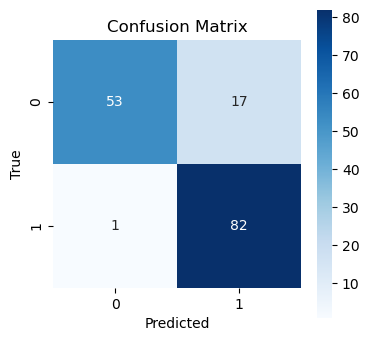

In [27]:
num_classes=2
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(num_classes*2, num_classes*2))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
report = classification_report(true_labels, predicted_labels)
print('\n'+ report)


              precision    recall  f1-score   support

           0       0.98      0.76      0.85        70
           1       0.83      0.99      0.90        83

    accuracy                           0.88       153
   macro avg       0.90      0.87      0.88       153
weighted avg       0.90      0.88      0.88       153

